In [1]:
# Numerical and data handling libraries
import numpy as np  # Library for numerical computations, arrays, and mathematical operations
import pandas as pd  # Library for data manipulation and analysis using DataFrames
import datetime  # Standard Python module for working with date and time objects

# Astronomical libraries
from astropy.time import Time  # Handles time conversions and formats used in astronomy
from astropy.table import vstack, Table, MaskedColumn  # Table operations for handling structured astronomical data

# Astronomical calculations for solar elevation and observer location
from astral import Observer  # Defines an observer’s location on Earth for solar calculations
from astral.sun import time_at_elevation  # Computes the time when the Sun reaches a specific elevation

# Visualization libraries
from matplotlib import pyplot as plt  # Core plotting library for data visualization
import matplotlib.dates as mdates  # Helper for formatting date/time data on Matplotlib plots

# HTTP and data retrieval libraries
import requests  # Library for making HTTP requests to fetch remote data
from pyvo.dal import tap  # Handles interaction with astronomical data archives via TAP (Table Access Protocol)

# File handling and system interaction
import os  # Provides functions for interacting with the operating system (e.g., file paths, directory handling)
import cgi  # Parses headers, often used for extracting filenames from HTTP responses
import shutil  # Enables high-level file operations such as copying and moving files
import subprocess  # Allows running system commands (used for uncompressing `.Z` files)

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_69159/4174731330.py:24: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi  # Parses headers, often used for extracting filenames from HTTP responses


In [ ]:
# Constants
ESO_TAP_OBS = "http://dfidev5.hq.eso.org:8123/tap_obs"
ESO_DOWNLOAD = 'https://dataportal.eso.org/dataPortal/file/'
OUTPUT_DIR = './data/'

# Paranal Observatory Coordinates
LATITUDE = -24.6275
LONGITUDE = -70.4042
ELEVATION = 2635

tapobs = tap.TAPService(ESO_TAP_OBS) # For the ESO TAP service

In [ ]:
# Define Observatory Location (Replace with actual latitude & longitude) - Paranal Observatory, Chile 
latitude = -24.6275  # Degrees
longitude = -70.4042 # Degrees
elevation = 2635  # Meters
observer = Observer(latitude, longitude, elevation)

# Define time range for 2024
# dates = [datetime.date(2024, 1, 1) + datetime.timedelta(days=i) for i in range(366)]
dates = [datetime.date(2024, 1, 1) + datetime.timedelta(days=i) for i in range(2)]

# Compute LST when Sun is -35 degrees below the horizon
lst_times = []
for date in dates:
    sun_time = time_at_elevation(observer, -35, date, direction='rising')
    lst_times.append(sun_time)

# Convert to MJD for TAP query
times = [Time(t).isot for t in lst_times]
times_mjd = Time(times).mjd

# Build queries for each day
query_template = (
    "SELECT TOP 50 * \n"
    "FROM ist.alpaca \n"
    "WHERE instrument = 'ALPACA' \n"
    "AND date_obs BETWEEN '{start_time}' AND '{end_time}' \n"
    "ORDER BY date_obs ASC \n"
)

results = []
columns = None  # To store column names for masked rows

for i, date in enumerate(dates):
    start_time = (Time(times[i]) - 0.02).isot  # Start time slightly before
    end_time = (Time(times[i]) + 0.02).isot  # End time slightly after
    query = query_template.format(start_time=start_time, end_time=end_time)
    
    print(f"Querying for: {date} at LST {times[i]}")
    result = tapobs.search(query) # Results output as astropy.table
    result = result.to_table()
    
    if result:
        # Store column names for masked rows
        if columns is None:
            columns = result.colnames
        
        # Convert date_obs column to Time format for comparison
        result_times = Time(list(result['date_obs'].data.data))
        target_time = Time(times[i])
        
        # Find the closest observation
        closest_index = np.argmin(np.abs(result_times - target_time))
        closest_result = result[closest_index]

        print(f"Closest observations found: {closest_result['date_obs']}")
        results.append(closest_result)
    else: 
        # Create a masked row with the same columns
        print(f"No observations found: {closest_result['date_obs']}")
        continue

# Stack results as astropy.table
if results:
    results = vstack(results, join_type='outer')

Querying for: 2024-01-01 at LST 2024-01-01T06:23:34.143
Closest observations found: 2024-01-01T06:23:08.420
Querying for: 2024-01-02 at LST 2024-01-02T06:24:42.415
Closest observations found: 2024-01-02T06:25:29.060


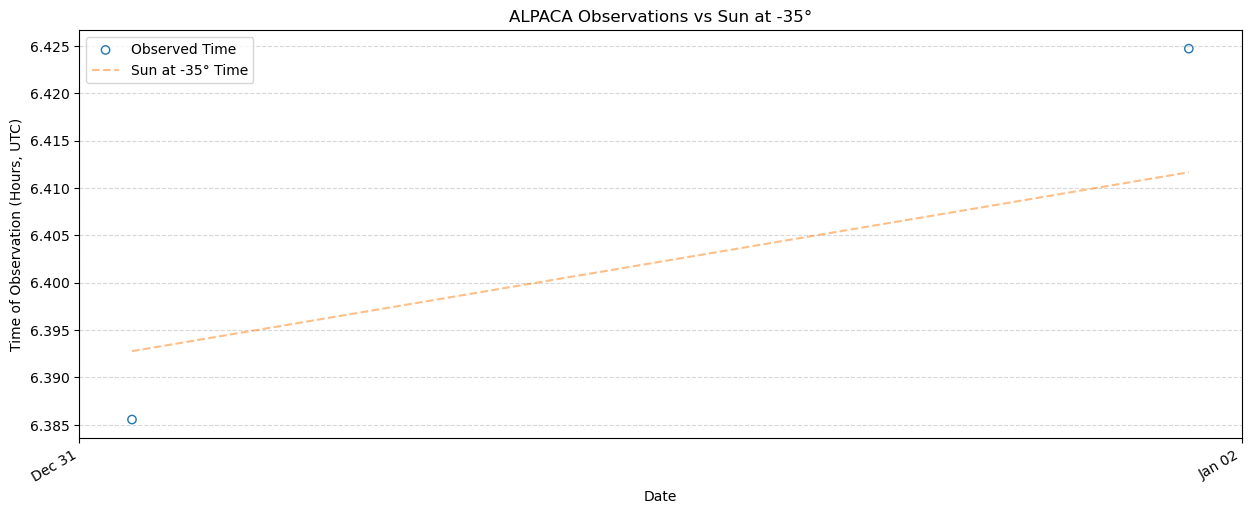

In [4]:
times_obs = [time for time in results['date_obs']]
times_obs_mjd = Time(times_obs).mjd

fig, ax = plt.subplots(figsize=(15, 6))

# Convert times to datetime objects
dates =     [t.datetime.date() for t in Time(times_obs_mjd, format='mjd')]
obs_times = [t.datetime for t in Time(times_obs_mjd, format='mjd')]  # Full datetime
obs_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in obs_times]  # Convert to fractional hours

# Convert Sun at -35° times
sun_dates = [t.datetime.date() for t in Time(times_mjd, format='mjd')]
sun_times = [t.datetime for t in Time(times, format='isot')]
sun_hours = [t.hour + t.minute / 60 + t.second / 3600 for t in sun_times]

# Scatter plot for observations
ax.scatter(dates, obs_hours, label="Observed Time", ec='C0', fc='none')

# Scatter plot for Sun at -35° times
# ax.scatter(sun_dates, sun_hours, label="Sun at -35° Time", color='C1', marker='x')
ax.plot(sun_dates, sun_hours, color='C1', ls='--', alpha=0.5, label="Sun at -35° Time")

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Month Day"
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Show ticks every 5 days
fig.autofmt_xdate()

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Time of Observation (Hours, UTC)")
ax.set_title("ALPACA Observations vs Sun at -35°")
ax.legend()
ax.grid(ls='--', alpha=0.5)

plt.show()

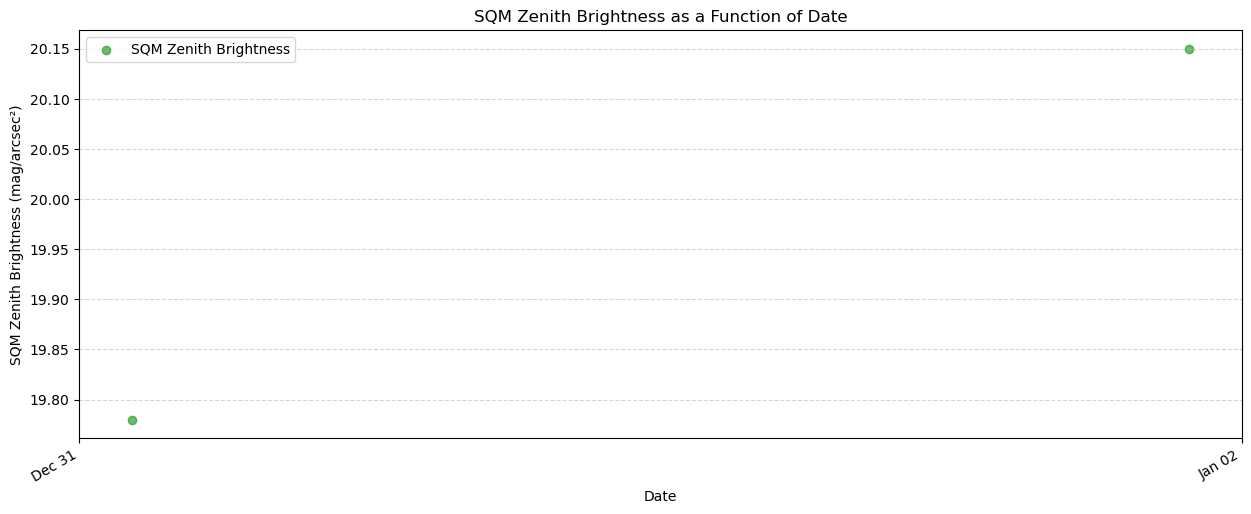

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time

# Convert date_obs to MJD
times_obs = [time for time in results['date_obs']]
times_obs_mjd = Time(times_obs).mjd

# Convert MJD to datetime
dates = [t.datetime.date() for t in Time(times_obs_mjd, format='mjd')]

# Extract SQM Zenith values
sqm_zen_values = results['sqm_zen']

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Scatter plot for SQM Zenith Brightness
ax.scatter(dates, sqm_zen_values, color='C2', label="SQM Zenith Brightness", alpha=0.7)

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
fig.autofmt_xdate()

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("SQM Zenith Brightness (mag/arcsec²)")
ax.set_title("SQM Zenith Brightness as a Function of Date")
ax.legend()
ax.grid(ls='--', alpha=0.5)

# Show the plot
plt.show()

In [6]:
def download_and_unpack_eso_files(results, output_dir='./data/', base_url=ESO_DOWNLOAD):
    """
    Downloads FITS files from the ESO data portal, saves them, and unpacks .Z files.

    Parameters:
    - results: List of dictionaries containing 'dp_id' keys.
    - output_dir: Directory to save downloaded files.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for ii, result in enumerate(results):
        file_url = f"{base_url}{result['dp_id']}"
        response = requests.get(file_url)

        if response.status_code == 200:
            # Extract filename from the response header
            content_disposition = response.headers.get('Content-Disposition')
            if content_disposition:
                _, params = cgi.parse_header(content_disposition)
                filename = params.get("filename", None)

                if filename:
                    file_path = os.path.join(output_dir, filename)

                    # Write file to disk
                    with open(file_path, 'wb') as f:
                        f.write(response.content)

                    print(f"Successfully Downloaded: {ii} - {filename}")

                    # Check if the file is compressed (.Z) and unpack it
                    if filename.endswith('.Z'):
                        uncompressed_filename = filename[:-2]  # Remove .Z extension
                        uncompressed_path = os.path.join(output_dir, uncompressed_filename)

                        # Use Unix `uncompress` command (ensure it's installed)
                        try:
                            subprocess.run(['uncompress', file_path], check=True)
                            print(f"Uncompressed: {uncompressed_filename}")
                        except FileNotFoundError:
                            print(f"Error: 'uncompress' command not found. Install with 'apt-get install ncompress' (Linux).")
                        except subprocess.CalledProcessError:
                            print(f"Error: Failed to uncompress {filename}.")
                else:
                    print(f"Error: Could not extract filename for {ii}.")

            else:
                print(f"Error: No Content-Disposition header for {ii}.")

        else:
            print(f"Not Downloaded (status {response.status_code}): {ii}")

download_and_unpack_eso_files(results)

Successfully Downloaded: 0 - ALPACA.2024-01-01T06:23:08.420.fits.Z
Uncompressed: ALPACA.2024-01-01T06:23:08.420.fits
Successfully Downloaded: 1 - ALPACA.2024-01-02T06:25:29.060.fits.Z
Uncompressed: ALPACA.2024-01-02T06:25:29.060.fits
